In [16]:
import contextualSpellCheck
import numpy as np
import pandas as pd
import spacy
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)

In [2]:
# default model for English
nlp = spacy.load("en_core_web_sm")
contextualSpellCheck.add_to_pipe(nlp)

In [3]:
# read in data
df1 = pd.read_csv("data/survey-data-1.csv")
df2 = pd.read_csv("data/survey-data-2.csv")

print(f"df1 length: {df1.shape[0]}, df2 length: {df2.shape[0]}")

# Some respondents appear in both data sets for coding purposes. Only keep one instance
# of them
df = pd.concat([df1, df2]).drop_duplicates(subset=["Respondent"])
print(f"df length: {df.shape[0]}")

df = df[
    [
        "Respondent",
        "Why public health scientists reliable or unreliable",
        "Why CDC changed recommended isolation period",
    ]
]

df.head()

df1 length: 500, df2 length: 401
df length: 800


,Respondent,Why public health scientists reliable or unreliable,Why CDC changed recommended isolation period
0,1.721090e+09,i have no idea,because they are unsure
1,1.721137e+09,What they say confirms the data I see.,Evidence
2,1.721195e+09,Basically every public health scientist in the...,Scientific and economic reasons
3,NaN,They can only do the best they can with limite...,It was the right thing to do.
4,1.721137e+09,Public health scientists are working daily to ...,I think it should be a 7-day minimum (days 0-6...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 400
Data columns (total 3 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Respondent                                           799 non-null    float64
 1   Why public health scientists reliable or unreliable  790 non-null    object 
 2   Why CDC changed recommended isolation period         797 non-null    object 
dtypes: float64(1), object(2)
memory usage: 25.0+ KB


In [9]:
def is_token_allowed(token: spacy.tokens.token.Token) -> bool:
    return token and token.text.strip() and not token.is_stop and not token.is_punct

# tokenization, lemmatization and stop-word + punctuation removal
def preprocess_text(x: str) -> str:
    if isinstance(x, str):
        return " ".join(
            token.lemma_.strip().lower()
            for token in nlp(x)
            if is_token_allowed(token)
        )
    return ""

In [11]:
%%time

df["scientists"] = df["Why public health scientists reliable or unreliable"].apply(
    preprocess_text
)
df["isolation"] = df["Why CDC changed recommended isolation period"].apply(
    preprocess_text
)

CPU times: user 27min 27s, sys: 2.53 s, total: 27min 30s
Wall time: 22min 54s


In [12]:
df.head()

,Respondent,Why public health scientists reliable or unreliable,Why CDC changed recommended isolation period,scientists,isolation
0,1.721090e+09,i have no idea,because they are unsure,idea,unsure
1,1.721137e+09,What they say confirms the data I see.,Evidence,confirm datum,evidence
2,1.721195e+09,Basically every public health scientist in the...,Scientific and economic reasons,basically public health scientist world focus ...,scientific economic reason
3,NaN,They can only do the best they can with limite...,It was the right thing to do.,good limited information,right thing
4,1.721137e+09,Public health scientists are working daily to ...,I think it should be a 7-day minimum (days 0-6...,public health scientist work daily tidal wave ...,think 7 day minimum day 0 6 negative rats day ...


TF-IDF score is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

In [13]:
# replicate td-idf outcomes

# small sample
example_corpus = [
    "I trust the scientists at the CDC.",
    "Scientists are not trustworthy.",
    "I trust my own opinions.",
]

example_corpus

['I trust the scientists at the CDC.',
 'Scientists are not trustworthy.',
 'I trust my own opinions.']

In [14]:
# the actual sentences used to compute tf-idf
for e in example_corpus:
    print(preprocess_text(e))

trust scientist cdc
scientist trustworthy
trust opinion


In [17]:
vectorizer = TfidfVectorizer()
tfidf_e = vectorizer.fit_transform(example_corpus)

dense = tfidf_e.todense()
denselist = dense.tolist()
readible_matrix = pd.DataFrame(denselist, columns=vectorizer.get_feature_names_out())

readible_matrix

,are,at,cdc,my,not,opinions,own,scientists,the,trust,trustworthy
0,0.000000,0.373801,0.373801,0.000000,0.000000,0.000000,0.000000,0.284285,0.747602,0.284285,0.000000
1,0.528635,0.000000,0.000000,0.000000,0.528635,0.000000,0.000000,0.402040,0.000000,0.000000,0.528635
2,0.000000,0.000000,0.000000,0.528635,0.000000,0.528635,0.528635,0.000000,0.000000,0.402040,0.000000


In [18]:
# manual calculation of td-idf score for one word from each sentence

# Sentence 1
# 6 words out of 7 fed into tfidfVectorizor
tf_sentence1 = {
    "trust": 1 / 6,
    "the": 2 / 6,
    "scientists": 1 / 6,
    "at": 1 / 6,
    "cdc": 1 / 6,
}

idf_sentence1 = {
    "trust": np.log((3 + 1) / (2 + 1)) + 1,
    "the": np.log((3 + 1) / (1 + 1)) + 1,
    "scientists": np.log((3 + 1) / (2 + 1)) + 1,
    "at": np.log((3 + 1) / (1 + 1)) + 1,
    "cdc": np.log((3 + 1) / (1 + 1)) + 1,
}

tfidf_sentence1 = {
    "trust": tf_sentence1["trust"] * idf_sentence1["trust"],
    "the": tf_sentence1["the"] * idf_sentence1["the"],
    "scientists": tf_sentence1["scientists"] * idf_sentence1["scientists"],
    "at": tf_sentence1["at"] * idf_sentence1["at"],
    "cdc": tf_sentence1["cdc"] * idf_sentence1["cdc"],
}

l2_norm = 0
for value in tfidf_sentence1.values():
    l2_norm = l2_norm + value**2
l2_norm = l2_norm**0.5

for key, value in tfidf_sentence1.items():
    tfidf_sentence1[key] = value / l2_norm

print(tfidf_sentence1)

{'trust': 0.2842853829563292, 'the': 0.7476022302779051, 'scientists': 0.2842853829563292, 'at': 0.37380111513895253, 'cdc': 0.37380111513895253}


In [19]:
# calculate TF-IDF score for "why public health scientiests reliable or unreliable"

corpus = df["Why public health scientists reliable or unreliable"].dropna().to_list()

vectorizer = TfidfVectorizer()
tfidf_corpus = vectorizer.fit_transform(corpus)

In [20]:
# get vector of selected doc
vector_tfidfvectorizer = tfidf_corpus[0]
# place tf-idf values in a pandas data frame
b = pd.DataFrame(
    vector_tfidfvectorizer.T.todense(),
    index=vectorizer.get_feature_names_out(),
    columns=["tfidf"],
)
b.sort_values(by=["tfidf"], ascending=False)

,tfidf
idea,0.789370
no,0.506707
have,0.346615
000,0.000000
positive,0.000000
...,...
first,0.000000
findings,0.000000
finding,0.000000
find,0.000000


In [21]:
# instantiate CountVectorizer()
cv = CountVectorizer()
# this steps generates word counts for the words in your docs
word_count_vector = cv.fit_transform(
    df["Why public health scientists reliable or unreliable"].dropna()
)

In [22]:
word_count_vector.shape

(790, 1782)

In [24]:
# Calculate idf values
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)
# print idf values
df_idf = pd.DataFrame(
    tfidf_transformer.idf_, index=cv.get_feature_names(), columns=["idf_weights"]
)
df_idf.sample(10)

/home/ubuntu/RIDOHCoding/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
term,6.063860
enforce,6.980151
likely,6.574686
intentions,6.980151
protections,6.980151
mandated,6.980151
always,4.415201
reopening,6.980151
flopping,6.574686
relay,6.980151


In [25]:
df_idf.sort_values(ascending=False, by="idf_weights")

,idf_weights
000,6.980151
moment,6.980151
motivations,6.980151
moral,6.980151
moonshine,6.980151
...,...
are,2.326190
to,2.184360
and,2.120338
the,1.829754


In [26]:
# count matrix
count_vector = cv.transform(
    df["Why public health scientists reliable or unreliable"].dropna()
)
# tf-idf scores
tf_idf_vector = tfidf_transformer.transform(count_vector)

In [27]:
feature_names = cv.get_feature_names_out()
# get tfidf vector for selected document
first_document_vector = tf_idf_vector[0]
# print the scores
vec = pd.DataFrame(
    first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]
)
vec.sort_values(by=["tfidf"], ascending=False)

,tfidf
idea,0.789370
no,0.506707
have,0.346615
000,0.000000
positive,0.000000
...,...
first,0.000000
findings,0.000000
finding,0.000000
find,0.000000


### WordCloud ###

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Why public health scientists reliable or unreliable?


(-0.5, 399.5, 199.5, -0.5)

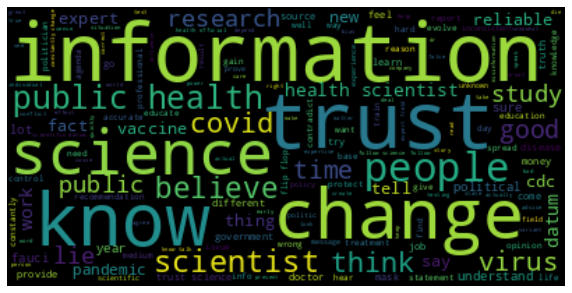

In [28]:
from wordcloud import WordCloud

text = " ".join(df.scientists.dropna().to_list())

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

print("Why public health scientists reliable or unreliable?")

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

Why CDC changed recommended isolation period?


(-0.5, 399.5, 199.5, -0.5)

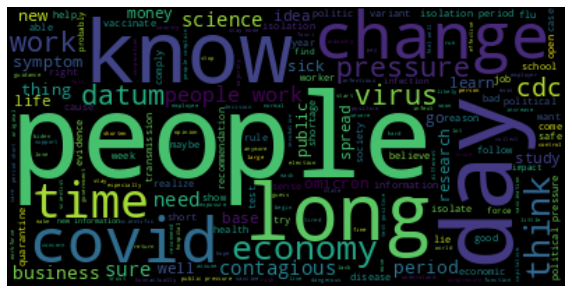

In [29]:
text = " ".join(df.isolation.dropna().to_list())

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

print("Why CDC changed recommended isolation period?")

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")